In [359]:
import os
import pathlib
import shutil
import glob
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
import numpy as np


In [251]:
MARGIN = 300

In [262]:
def calc_time(folder):
    files = glob.glob(folder + "/*time.txt")
    time = 99999999.0
    for file in files:
        with open(file , "r") as rfile:
            rtime = float(rfile.readline())
            if rtime < time:
                time = rtime 
    return time / 60.0

def calc_dist(x1, y1, x2, y2):
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

def calc_odometry(folder):
    files = glob.glob(folder + "/*path.txt")
    dist = {"total": 0}
    for file in files:
        lst = file.split("_")
        robot = lst[len(lst) -2]
        if robot not in dist:
            dist[robot] = 0
        with open(file, 'r') as rfile:
            pos = rfile.readline().split()
            x = float(pos[0])
            y = float(pos[1])
            for line in rfile:
                pos = line.split()
                x_new = float(pos[0])
                y_new = float(pos[1])
                path = calc_dist(x, y, x_new, y_new)
                dist[robot] += path
                dist["total"] += path
                x = x_new
                y = y_new
    return dist

def calc_quality(folder, ground_truth, nrobot):
    gt = ground_truth[MARGIN:-MARGIN, MARGIN:-MARGIN].copy()
    quality = {}
    for x in range(0,int(nrobot)):
        quality[str(x)] = {}
        files = glob.glob(folder + "/robot_" + str(x) + "*.png")
        map_file = folder + "/robot_" + str(x) + "_" + str(len(files)-1) + ".png"
        rmap = cv.imread(map_file, 0)[MARGIN:-MARGIN, MARGIN:-MARGIN]
        ssim = structural_similarity(gt, rmap, data_range=gt.max() - gt.min())
        quality[str(x)]["mse"] = mean_squared_error(gt, rmap)
        quality[str(x)]["ssim"] = structural_similarity(gt, rmap, data_range=gt.max() - gt.min())

    return quality

In [460]:
def read_files(run):
    config_dir = str(pathlib.Path().absolute().parent) + '/files/' + run + '/'
    folders = [ name for name in os.listdir(config_dir) if os.path.isdir(os.path.join(config_dir, name)) ]
    runs = {} 
    for folder in folders:
        if folder[:len(folder)-2] not in runs:
            runs[folder[:len(folder)-2]] = []
        runs[folder[:len(folder)-2]].append(folder)
    return runs

def read_config(run, folders, config, ground_truth):
    configs = config.split("_")
    nrobot = configs[0]
    alpha = configs[1]
    beta = configs[2]
    nsize = configs[3]
    sigma = configs[4]
    prefix_dir = str(pathlib.Path().absolute().parent) + '/files/' + run + '/'
    plans = []
    time = []
    odometry = []
    quality = []
    not_started = 0
    total = 0
    for folder in folders[config]:
        run_dir = prefix_dir + folder
        maps = [f for f in glob.glob(run_dir + "/*.png")]
        if len(maps) <= 1:
            not_started += 1
            continue

        plans.append(len(maps))
        print(folder)
        time.append(calc_time(run_dir))
        odometry.append(calc_odometry(run_dir))
        quality.append(calc_quality(run_dir, ground_truth, nrobot))
        total += 1
    
    results = {
        "n_plans": plans,
        "time": time
    }

    for item in odometry:
        for r in item:
            if "odometry_" + r not in results:
                results["odometry_" + r] = []
            results["odometry_" + r].append(item[r])

    for item in quality:
        for robot in item:
            for metric in item[robot]:
                if metric + "_" + robot not in results:
                    results[metric + "_" + robot] = []
                results[metric + "_" + robot].append(item[robot][metric])
    mean_std = {}
    for item in results:
        mean_std[item + "_mean"] = np.mean(results[item])
        mean_std[item + "_std"] = np.std(results[item])
    
    results["not_started"] = not_started
    results["total"] = total
    results["config"] = config

    return {**results, **mean_std}

        
        



In [335]:
config = "single_robot_dist_cost"
ground_truth = cv.imread("../ground_truth/cave.png", 0)
files = read_files(run=config)

In [336]:
dist_cost = []
for x in files:
    aux = {}
    aux = read_config(config, files, x, ground_truth)
    if aux['total'] > 6:
        dist_cost.append(aux)


In [337]:
config = "single_robot_inf_gain"
ground_truth = cv.imread("../ground_truth/cave.png", 0)
files = read_files(run=config)

In [338]:
inf_gain = []
for x in files:
    aux = {}
    aux = read_config(config, files, x, ground_truth)
    if aux['total'] > 6:
        inf_gain.append(aux)

In [443]:
def calculate_norm(data):
    min_odom = min_time = min_quality = 9999999.9
    max_odom = max_time = max_quality = 0.0
    for item in data:
        if item['odometry_total_mean'] > max_odom:
            max_odom = item['odometry_total_mean']
        if item['odometry_total_mean'] < min_odom:
            min_odom = item['odometry_total_mean']
        if item['time_mean'] > max_time:
            max_time = item['time_mean']
        if item['time_mean'] < min_time:
            min_time = item['time_mean']
        if item['ssim_0_mean'] > max_quality:
            max_quality = item['ssim_0_mean']
        if item['ssim_0_mean'] < min_quality:
            min_quality = item['ssim_0_mean']
    for item in data:
        item['norm_odom'] = (item['odometry_total_mean'] - min_odom) / (max_odom - min_odom)
        item['norm_time'] = (item['time_mean'] - min_time) / (max_time - min_time)
        item['norm_quality'] = 1 - (item['ssim_0_mean'] - min_quality) / (max_quality - min_quality)
        item['zero_dist'] = math.sqrt(item['norm_odom']*item['norm_odom'] + item['norm_quality']*item['norm_quality'] + item['norm_time']*item['norm_time'])

In [444]:
calculate_norm(dist_cost)
calculate_norm(inf_gain) 

In [446]:
font = {"weight" : "bold"}
font_ticks = {
    "labelsize": 10}
font_axes = {
    'titlesize' : 20,
    'labelsize'   : 20}
font_legend = {
    'fontsize' : 22}
matplotlib.rc("font", **font)
matplotlib.rc('xtick', **font_ticks) 
matplotlib.rc('ytick', **font_ticks)
matplotlib.rc('axes', **font_axes)

In [447]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation
class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)

def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)


In [468]:
def plot_scatter(x_name, y_name, z_name, data, title, config1, config2):
    xs = []
    ys = []
    zs = []
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')

    for item in data:
        print(item['config'])
        label = item['config'].split('_')
        xs.append(item[x_name])
        ys.append(item[y_name])
        zs.append(item[z_name])
        annotate3D(ax, s=label[config1] + ', ' + label[config2], xyz=(item[x_name], item[y_name], item[z_name]), fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')    
    
    
    ax.scatter(xs, ys, zs=zs, zdir='z', s=40, c=None, depthshade=True)
    ax.set_xlabel("Odometry", labelpad=20)
    ax.set_ylabel("Time", labelpad=20)
    ax.set_zlabel("Map Quality", labelpad=20)
    ax.set_title(title, pad=30)
    plt.show()



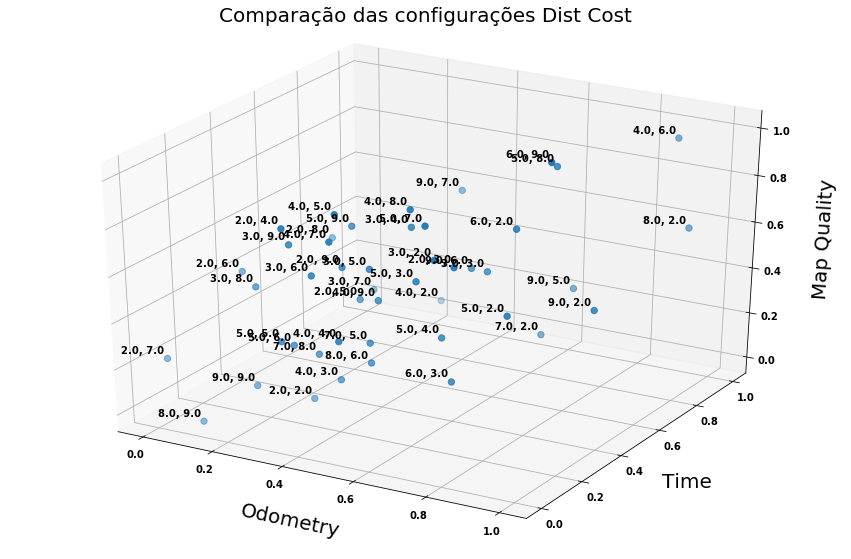

In [441]:
plot_scatter('norm_odom', 'norm_time', 'norm_quality', dist_cost, "Comparação das configurações Dist Cost", 1, 2)

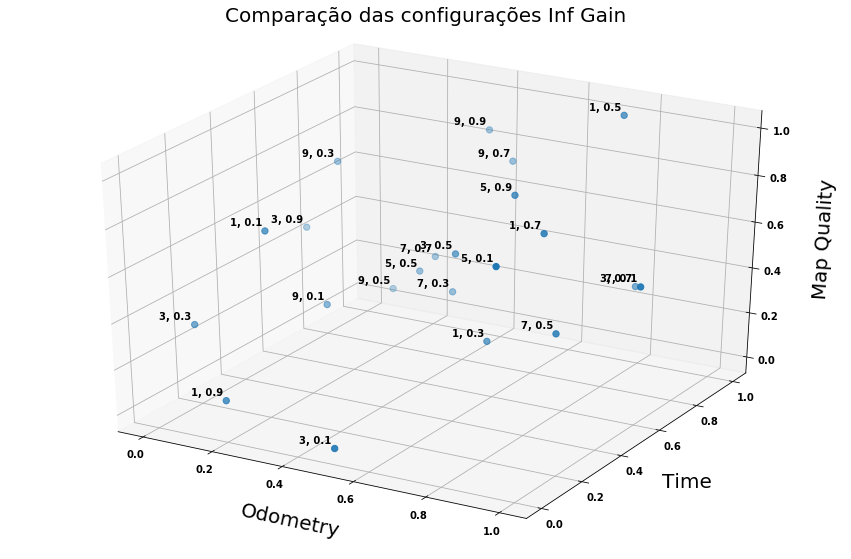

In [442]:
plot_scatter('norm_odom', 'norm_time', 'norm_quality', inf_gain, "Comparação das configurações Inf Gain", 3, 4)

In [455]:
def get_best_configs(data):
    best = sorted(data, key=lambda k: k['zero_dist'])[:3]
    for item in best:
        print(item['config'])

In [456]:
get_best_configs(dist_cost)
get_best_configs(inf_gain)

1_8.0_9.0_1_0.1
1_2.0_7.0_1_0.1
1_9.0_9.0_1_0.1
1_1_1_1_0.9
1_1_1_3_0.3
1_1_1_3_0.1


In [457]:
### Multi Robot

In [474]:
config = "single_robot_dist_cost_inf_gain"
ground_truth = cv.imread("../ground_truth/cave.png", 0)
files = read_files(run=config)

In [475]:
dist_cost_inf_gain = []
for x in files:
    aux = {}
    aux = read_config(config, files, x, ground_truth)
    if aux['total'] > 6:
        dist_cost_inf_gain.append(aux)

1_8.0_9.0_3_0.1_0
1_8.0_9.0_3_0.1_9
1_8.0_9.0_3_0.1_3
1_8.0_9.0_3_0.1_7
1_8.0_9.0_3_0.1_4
1_8.0_9.0_3_0.1_2
1_8.0_9.0_3_0.1_5
1_8.0_9.0_3_0.1_1
1_8.0_9.0_3_0.1_6
1_8.0_9.0_3_0.3_7
1_8.0_9.0_3_0.3_3
1_8.0_9.0_3_0.3_0
1_8.0_9.0_3_0.3_8
1_8.0_9.0_3_0.3_6
1_8.0_9.0_3_0.3_9
1_8.0_9.0_3_0.3_4
1_8.0_9.0_3_0.3_1
1_8.0_9.0_3_0.3_2
1_8.0_9.0_3_0.3_5
1_9.0_9.0_3_0.3_9
1_9.0_9.0_3_0.3_4
1_9.0_9.0_3_0.3_8
1_9.0_9.0_3_0.3_6
1_9.0_9.0_3_0.3_1
1_9.0_9.0_3_0.3_0
1_9.0_9.0_3_0.3_7
1_9.0_9.0_3_0.3_3
1_9.0_9.0_3_0.3_2
1_2.0_7.0_1_0.9_3
1_2.0_7.0_1_0.9_2
1_2.0_7.0_1_0.9_8
1_2.0_7.0_1_0.9_9
1_2.0_7.0_1_0.9_0
1_2.0_7.0_1_0.9_7
1_2.0_7.0_1_0.9_6
1_2.0_7.0_1_0.9_4
1_2.0_7.0_1_0.9_1
1_2.0_7.0_1_0.9_5
1_2.0_7.0_3_0.1_2
1_2.0_7.0_3_0.1_1
1_2.0_7.0_3_0.1_0
1_2.0_7.0_3_0.1_8
1_2.0_7.0_3_0.1_5
1_2.0_7.0_3_0.1_7
1_2.0_7.0_3_0.1_9
1_2.0_7.0_3_0.1_4
1_2.0_7.0_3_0.1_3
1_2.0_7.0_3_0.1_6
1_2.0_7.0_3_0.3_8
1_2.0_7.0_3_0.3_1
1_2.0_7.0_3_0.3_7
1_2.0_7.0_3_0.3_9
1_2.0_7.0_3_0.3_3
1_2.0_7.0_3_0.3_4
1_2.0_7.0_3_0.3_5
1_2.0_7.0_

In [476]:
calculate_norm(dist_cost_inf_gain) 

1_8.0_9.0_3_0.1
1_8.0_9.0_3_0.3
1_9.0_9.0_3_0.3
1_2.0_7.0_1_0.9
1_2.0_7.0_3_0.1
1_2.0_7.0_3_0.3
1_9.0_9.0_3_0.1
1_8.0_9.0_1_0.9
1_9.0_9.0_1_0.9


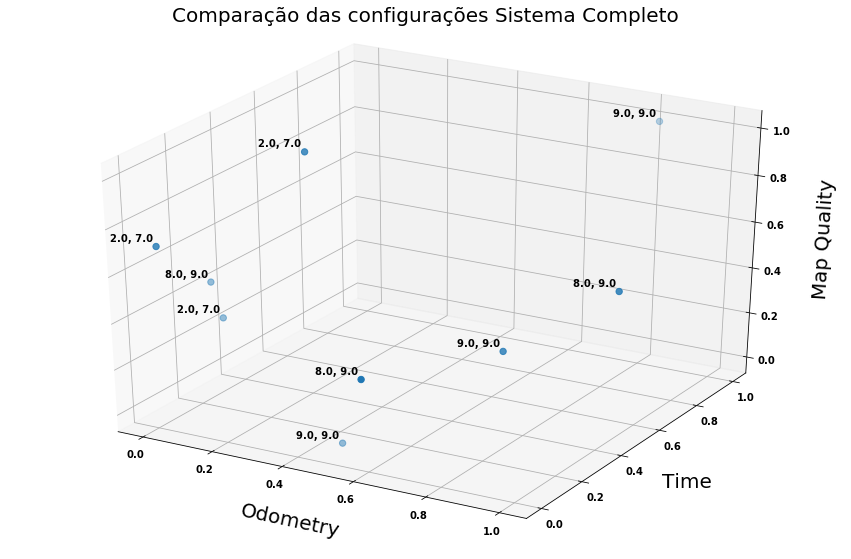

In [477]:
plot_scatter('norm_odom', 'norm_time', 'norm_quality', dist_cost_inf_gain, "Comparação das configurações Sistema Completo", 1, 2)

In [478]:
get_best_configs(dist_cost_inf_gain)


1_2.0_7.0_1_0.9
1_9.0_9.0_3_0.3
1_8.0_9.0_3_0.1
